<a href="https://colab.research.google.com/github/niteshydv01/Chextray/blob/main/Chextray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade kaggle


In [2]:
from google.colab import files

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
# Replace 'dataset-name' with the actual name of the Kaggle dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
##!kaggle datasets download -d andrewmvd/face-mask-detection

 99% 2.28G/2.29G [00:22<00:00, 185MB/s]
100% 2.29G/2.29G [00:22<00:00, 110MB/s]


In [5]:
!unzip -q /content/chest-xray-pneumonia.zip


In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


In [7]:
# Assuming the dataset is organized in folders 'train' and 'test' with subfolders 'NORMAL' and 'PNEUMONIA'
train_path = '/content/chest_xray/train'
test_path = '/content/chest_xray/test'

# Create dataframes with image file paths and labels
def load_data(folder_path):
    data = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        for file in os.listdir(label_path):
            file_path = os.path.join(label_path, file)
            data.append((file_path, label))
    return pd.DataFrame(data, columns=['File', 'Label'])

train_df = load_data(train_path)
test_df = load_data(test_path)


In [8]:
# Display the first few rows of the dataframes
print("Train Data:")
print(train_df.head())

print("\nTest Data:")
print(test_df.head())

# Summary statistics
print("\nTrain Data Summary:")
print(train_df['Label'].value_counts())

print("\nTest Data Summary:")
print(test_df['Label'].value_counts())


Train Data:
                                                File      Label
0  /content/chest_xray/train/PNEUMONIA/person1188...  PNEUMONIA
1  /content/chest_xray/train/PNEUMONIA/person745_...  PNEUMONIA
2  /content/chest_xray/train/PNEUMONIA/person1308...  PNEUMONIA
3  /content/chest_xray/train/PNEUMONIA/person1048...  PNEUMONIA
4  /content/chest_xray/train/PNEUMONIA/person755_...  PNEUMONIA

Test Data:
                                                File      Label
0  /content/chest_xray/test/PNEUMONIA/person56_vi...  PNEUMONIA
1  /content/chest_xray/test/PNEUMONIA/person119_b...  PNEUMONIA
2  /content/chest_xray/test/PNEUMONIA/person19_vi...  PNEUMONIA
3  /content/chest_xray/test/PNEUMONIA/person61_vi...  PNEUMONIA
4  /content/chest_xray/test/PNEUMONIA/person173_b...  PNEUMONIA

Train Data Summary:
PNEUMONIA    3875
NORMAL       1341
Name: Label, dtype: int64

Test Data Summary:
PNEUMONIA    390
NORMAL       234
Name: Label, dtype: int64


In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint


In [10]:
# Set the paths to the train and test datasets
train_path = '/content/chest_xray/train'
test_path = '/content/chest_xray/test'

# Data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and augment the training data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

# Load the test data without augmentation
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [12]:
# Define a checkpoint to save the best model
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint]
)


Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 0.3417 - accuracy: 0.8474
Epoch 1: val_loss improved from inf to 0.32080, saving model to best_model.h5
163/163 [==============================] - 244s 1s/step - loss: 0.3417 - accuracy: 0.8474 - val_loss: 0.3208 - val_accuracy: 0.8701
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - ETA: 0s - loss: 0.2186 - accuracy: 0.9084
Epoch 2: val_loss did not improve from 0.32080
163/163 [==============================] - 240s 1s/step - loss: 0.2186 - accuracy: 0.9084 - val_loss: 0.5069 - val_accuracy: 0.8224
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.9216
Epoch 3: val_loss did not improve from 0.32080
163/163 [==============================] - 241s 1s/step - loss: 0.1939 - accuracy: 0.9216 - val_loss: 0.4884 - val_accuracy: 0.8487
Epoch 4/10
163/163 [==============================] - ETA: 0s - loss: 0.1711 - accuracy: 0.9289
Epoch 4: val_loss did not improve from 0.32080
163/163 [==============================] - 238s 1s/step - loss: 0.1711 - accuracy: 0.9289 - val_loss: 0.6230 - val_accuracy: 0.8240
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.1653 - accuracy: 0.9375
Epoch 5: val_loss did not improve from 0.32080
163/163 [==============================] - 

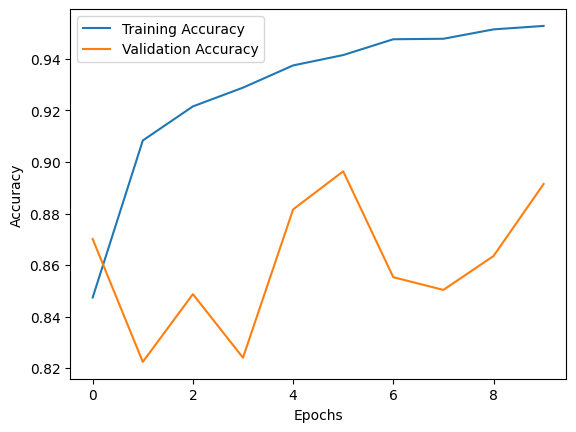

20/20 [==============================] - 19s 888ms/step - loss: 0.4754 - accuracy: 0.8926
Test Accuracy: 89.26%


In [13]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
eval_result = model.evaluate(test_generator)
print(f'Test Accuracy: {eval_result[1]*100:.2f}%')
